이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [12]:
# DataFrame 생성 (데이터를 2차원으로 변환 후 레이블 추가)
flattened_data = X_train.reshape(X_train.shape[0], -1)
train_df = pd.DataFrame(flattened_data)
train_df['label'] = y_train

# 1. 데이터 요약 통계
print("1. 데이터 요약 통계:")
print(train_df.describe(), "\n")

# 2. 데이터의 모양과 크기
print("2. 데이터의 모양과 크기:")
print(f"행 수: {train_df.shape[0]}, 열 수: {train_df.shape[1]}\n")

# 3. 결측치 여부 확인
print("3. 결측치 여부:")
print(train_df.isnull().sum().sum(), "개의 결측치가 있습니다.\n")

# 4. 데이터 타입 확인
print("4. 데이터 타입:")
print(train_df.dtypes, "\n")

# 5. 레이블 분포 확인
print("5. 레이블 분포:")
print(train_df['label'].value_counts(), "\n")

1. 데이터 요약 통계:
                  0             1             2             3             4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000800      0.005783      0.030083      0.103800      0.249683   
std        0.092554      0.249033      0.767868      2.512017      4.331376   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       16.000000     36.000000    119.000000    164.000000    224.000000   

                  5             6             7             8             9  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.414717      0.821667      2.224733      5.698667     14.434650   
std        5.827394      8.309935    

### Data중 첫 번째 이미지를 보여주세요.

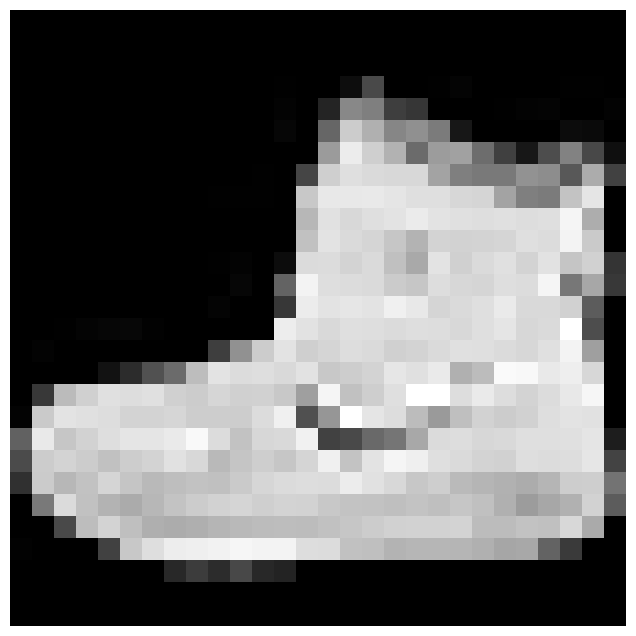

In [14]:
first_image = X_train[0]

plt.figure(figsize=(8, 8))
plt.imshow(first_image, cmap='gray')
plt.axis('off') 
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [5]:
# 데이터 변환 및 정규화 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [7]:
X_train = X_train.reshape(-1, 28*28) / 255.0

print("max pixel:", X_train.max())
print("min pixel:", X_train.min())

max pixel: 1.0
min pixel: 0.0


### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

def preprocess_fashion_mnist(images):
    processed_images = images.copy()

    # 1. 데이터 증강
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    
    # 데이터 증강 적용
    processed_images = np.array([datagen.random_transform(img.reshape(28, 28, 1)) for img in processed_images])
    
    # 2. 랜덤 지우기
    def random_erasing(image, probability=0.5, sl=0.02, sh=0.4, r1=0.3, r2=1/0.3):
        if np.random.rand() > probability:
            return image
        
        for attempt in range(100):
            area = image.shape[0] * image.shape[1]
            target_area = np.random.uniform(sl, sh) * area
            aspect_ratio = np.random.uniform(r1, r2)
            
            h = int(round(np.sqrt(target_area * aspect_ratio)))
            w = int(round(np.sqrt(target_area / aspect_ratio)))
            
            if w < image.shape[1] and h < image.shape[0]:
                x1 = np.random.randint(0, image.shape[1] - w)
                y1 = np.random.randint(0, image.shape[0] - h)
                image[y1:y1+h, x1:x1+w] = np.random.rand()
                return image
        
        return image
    
    processed_images = np.array([random_erasing(img.reshape(28, 28)) for img in processed_images])
    
    # 3. 가우시안 노이즈 추가
    def add_gaussian_noise(image, mean=0, std=0.1):
        noise = np.random.normal(mean, std, image.shape)
        noisy_image = image + noise
        return np.clip(noisy_image, 0, 1) 
    
    processed_images = np.array([add_gaussian_noise(img) for img in processed_images])
    
    return processed_images.reshape(-1, 28, 28, 1)

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

pca로는 멀리 있는 점도 모두 같게 표현된다는 단점이 있었지만 t-sne는 멀리 떨어진 점보다 가까이 있는 점에 더 많은 비중을 주는 방법이다. 즉, t-sne는 pca 방식의 단점을 보완한 방법이다.

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [11]:
# PCA 변환 함수
def pca_transform(X, n_components=50):
    # 데이터 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # 데이터 재구성
    X_reconstructed = pca.inverse_transform(X_pca)
    
    return X_pca, pca, X_scaled, X_reconstructed

# Fashion MNIST 데이터 로드 및 PCA 변환 적용
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# 데이터를 2D에서 1D로 평탄화
X_train_flattened = X_train.reshape(-1, 28 * 28)

# PCA 변환 함수 적용
X_transformed, pca_obj, X_scaled, X_reconstructed = pca_transform(X_train_flattened)

print(f"원본 데이터 형태: {X_train_flattened.shape}")
print(f"변환된 데이터 형태: {X_transformed.shape}")

원본 데이터 형태: (60000, 784)
변환된 데이터 형태: (60000, 50)


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [20]:
print(f"\n설명된 분산 비율의 합: {pca_obj.explained_variance_ratio_.sum():.4f}")


설명된 분산 비율의 합: 0.8006


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [13]:
# PCA 변환 함수 적용
_, pca_obj, X_scaled, X_reconstructed = pca_transform(X_train_flattened)

# 재구성 오차 계산 (MSE)
mse = mean_squared_error(X_scaled, X_reconstructed)
print(f"재구성 오차 (MSE): {mse:.4f}")

재구성 오차 (MSE): 0.1994


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [17]:
# PCA 변환 함수
def pca_transform_30(X, n_components=30):
    # 데이터 정규화
    scaler_30 = StandardScaler()
    X_scaled_30 = scaler_30.fit_transform(X)
    
    # PCA 적용
    pca_30 = PCA(n_components=n_components)
    X_pca_30 = pca_30.fit_transform(X_scaled_30)

    # 데이터 재구성
    X_reconstructed_30 = pca_30.inverse_transform(X_pca_30)
    
    return X_pca_30, pca_30, X_scaled_30, X_reconstructed_30
    
# Fashion MNIST 데이터 로드 및 PCA 변환 적용
(X_train_30, y_train_30), (_, _) = fashion_mnist.load_data()

# 데이터를 2D에서 1D로 평탄화
X_train_flattened_30 = X_train_30.reshape(-1, 28 * 28)

# PCA 변환 함수 적용
X_transformed_30, pca_obj_30, X_scaled_30, X_reconstructed_30 = pca_transform_30(X_train_flattened_30)

print(f"변환된 데이터 형태 (30차원): {X_transformed_30.shape}")

print(f"\n설명된 분산 비율의 합 (30차원): {pca_obj_30.explained_variance_ratio_.sum():.4f}")

# 재구성 오차 계산 (MSE)
mse = mean_squared_error(X_scaled_30, X_reconstructed_30)
print(f"재구성 오차 (MSE): {mse:.4f}")

변환된 데이터 형태 (30차원): (60000, 30)

설명된 분산 비율의 합 (30차원): 0.7442
재구성 오차 (MSE): 0.2558


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

50차원은 원본 데이터의 약 80%를 설명하는 반면, 30차원은 약 74%를 설명한다.
30차원 모델의 재구성 오차(0.1994)가 30차원 모델(0.2558)보다 낮다. 즉, 50차원 모델이 원본 데이터를 더 정확하게 재구성할 수 있음을 의미한다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [19]:
# PCA 변환 함수 
def pca_transform_2(X, n_components=2):
    # 데이터 정규화
    scaler_2 = StandardScaler()
    X_scaled_2 = scaler_2.fit_transform(X)
    
    # PCA 적용
    pca_2 = PCA(n_components=n_components)
    X_pca_2 = pca_2.fit_transform(X_scaled_2)

    # 데이터 재구성
    X_reconstructed_2 = pca_2.inverse_transform(X_pca_2)
    
    return X_pca_2, pca_2, X_scaled_2, X_reconstructed_2
    
# Fashion MNIST 데이터 로드 및 PCA 변환 적용
(X_train_2, y_train_2), (_, _) = fashion_mnist.load_data()

# 데이터를 2D에서 1D로 평탄화
X_train_flattened_2 = X_train_2.reshape(-1, 28 * 28)

# PCA 변환 함수 적용
X_transformed_2, pca_obj_2, X_scaled_2, X_reconstructed_2 = pca_transform_2(X_train_flattened_2)

print(f"변환된 데이터 형태 (2차원): {X_transformed_2.shape}")

print(f"\n설명된 분산 비율의 합 (2차원): {pca_obj_2.explained_variance_ratio_.sum():.4f}")

# 재구성 오차 계산 (MSE)
mse = mean_squared_error(X_scaled_2, X_reconstructed_2)
print(f"재구성 오차 (MSE): {mse:.4f}")

변환된 데이터 형태 (2차원): (60000, 2)

설명된 분산 비율의 합 (2차원): 0.3650
재구성 오차 (MSE): 0.6350


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

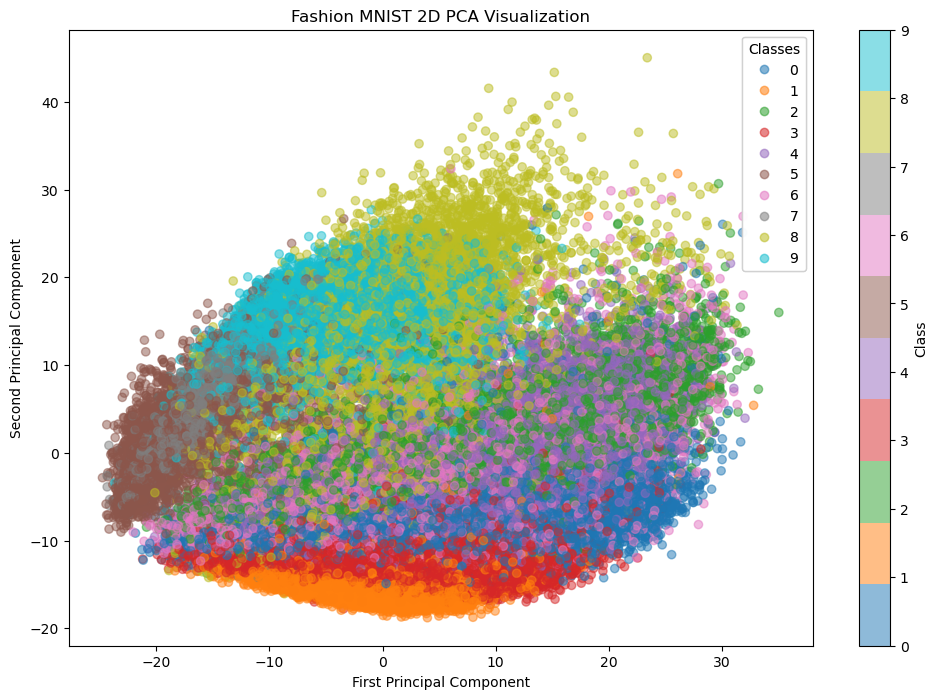

In [21]:
# 데이터 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_transformed_2[:, 0], X_transformed_2[:, 1], c=y_train, cmap='tab10', alpha=0.5)

# 범례 추가
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)

plt.title('Fashion MNIST 2D PCA Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Class')
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

X_transformed shape: (60000, 50)
y_train shape: (60000,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.030s...
[t-SNE] Computed neighbors for 1000 samples in 1.457s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.152767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.690582
[t-SNE] KL divergence after 1000 iterations: 0.688615


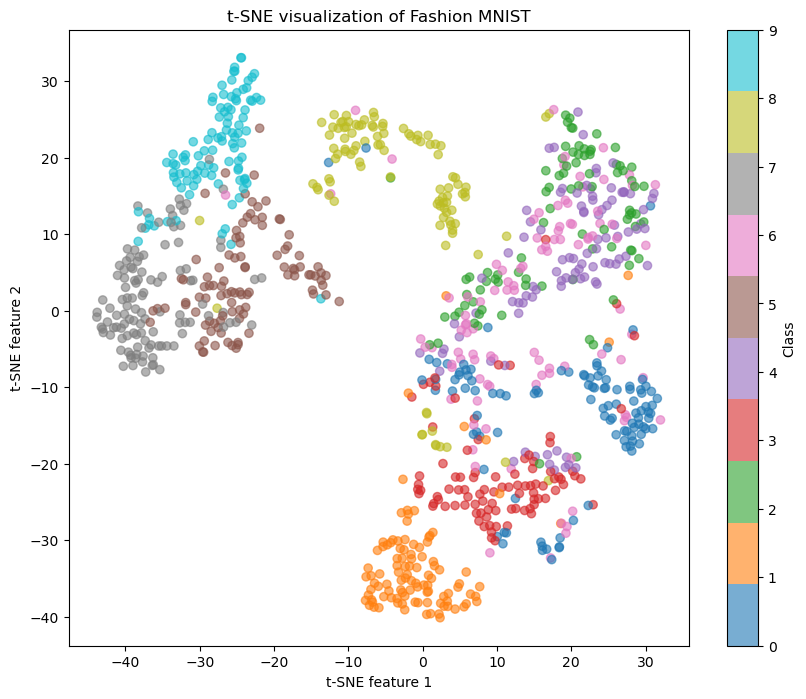

In [23]:
# 데이터 준비 확인
print("X_transformed shape:", X_transformed.shape)
print("y_train shape:", y_train.shape)

# 샘플링
X_sample, y_sample = X_transformed[:1000], y_train[:1000]

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42, verbose=1)
X_tsne = tsne.fit_transform(X_sample)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='tab10', alpha=0.6)

# 범례 추가
plt.title('t-SNE visualization of Fashion MNIST')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Class')
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

X_transformed_30 shape: (60000, 30)
y_train_30 shape: (60000,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 6.516065
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.221725
[t-SNE] KL divergence after 1000 iterations: 0.660229


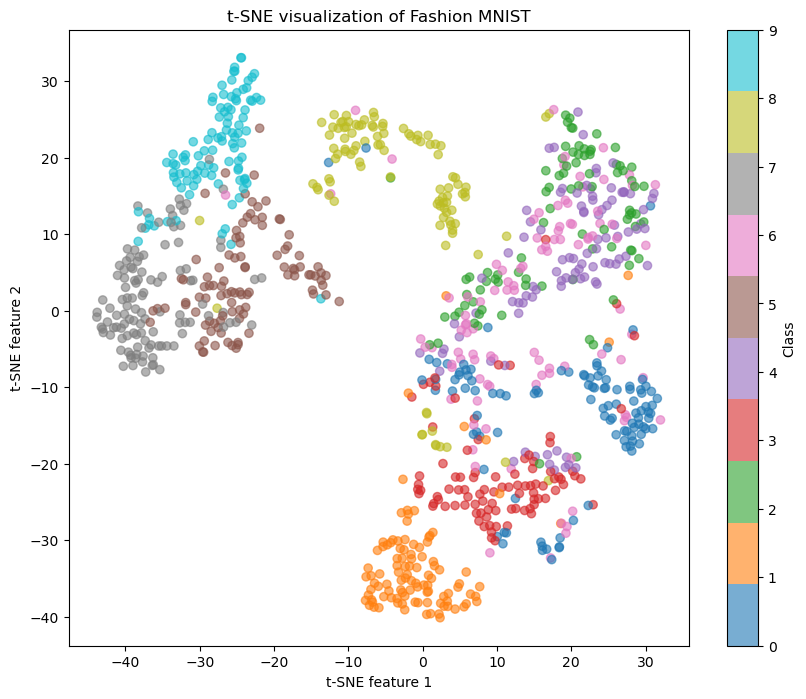

In [25]:
# 데이터 준비 확인
print("X_transformed_30 shape:", X_transformed_30.shape)
print("y_train_30 shape:", y_train_30.shape)

# 샘플링
X_sample_30, y_sample_30 = X_transformed_30[:1000], y_train_30[:1000]

# t-SNE 적용
tsne_30 = TSNE(n_components=2, random_state=42, verbose=1)
X_tsne_30 = tsne_30.fit_transform(X_sample_30)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='tab10', alpha=0.6)

# 범례 추가
plt.title('t-SNE visualization of Fashion MNIST')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Class')
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [27]:
# DBSCAN 군집화 적용
dbscan = DBSCAN(eps=5, min_samples=10)
clusters = dbscan.fit_predict(X_transformed)

# 군집 결과 요약 출력
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"군집 수: {n_clusters}")
print(f"노이즈 포인트 수: {n_noise}")

군집 수: 35
노이즈 포인트 수: 47269


### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [29]:
# K-means 군집화 적용
n_clusters = 10 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_transformed)

# 군집 결과 요약 출력
print(f"군집 수: {n_clusters}")
print(f"각 군집의 샘플 수:")
for i in range(n_clusters):
    print(f"  군집 {i}: {np.sum(clusters == i)}")

군집 수: 10
각 군집의 샘플 수:
  군집 0: 6043
  군집 1: 7558
  군집 2: 3714
  군집 3: 5561
  군집 4: 8961
  군집 5: 7723
  군집 6: 8094
  군집 7: 2263
  군집 8: 7618
  군집 9: 2465


### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

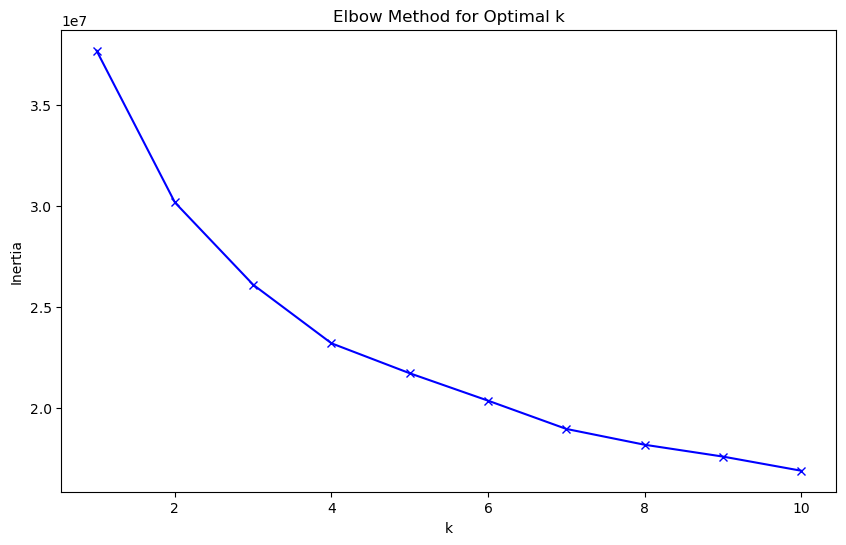

엘보우 메소드로 추정된 최적의 군집 수: 1

최적 군집 수: 1
각 군집의 샘플 수:
  군집 0: 60000


In [31]:
# 엘보우 메소드 적용
inertias = []
K = range(1, 11) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    inertias.append(kmeans.inertia_)

# 엘보우 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# 엘보우 포인트 찾기 (간단한 방법)
diffs = np.diff(inertias)
elbow_point = np.argmin(diffs) + 1

print(f"엘보우 메소드로 추정된 최적의 군집 수: {elbow_point}")

# 최적의 군집 수로 K-means 실행
optimal_kmeans = KMeans(n_clusters=elbow_point, random_state=42)
clusters = optimal_kmeans.fit_predict(X_transformed)

# 결과 출력
print(f"\n최적 군집 수: {elbow_point}")
print("각 군집의 샘플 수:")
for i in range(elbow_point):
    print(f"  군집 {i}: {np.sum(clusters == i)}")

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

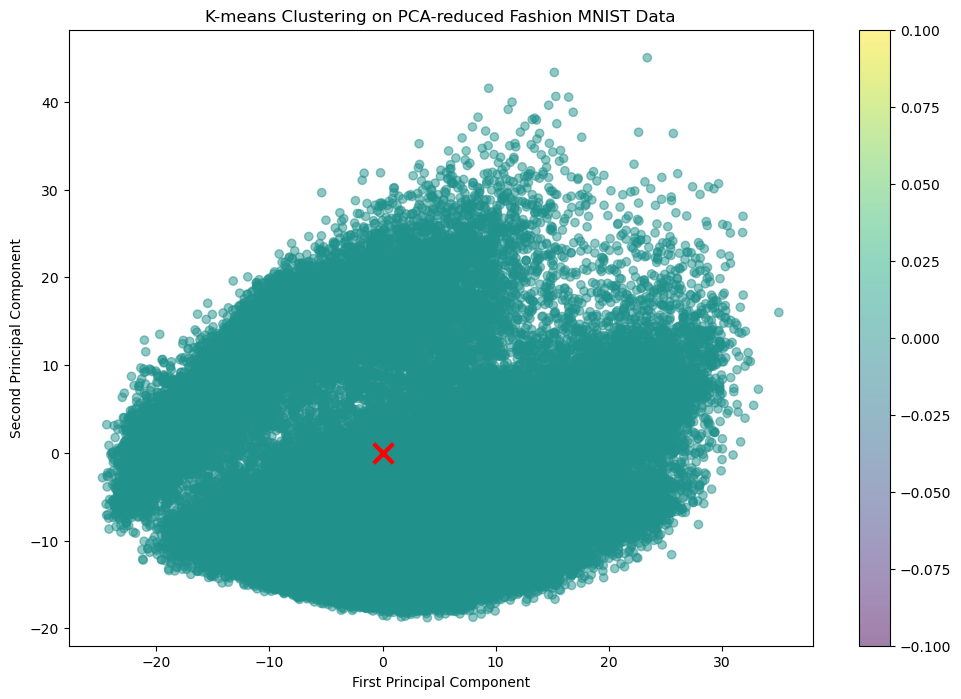

In [33]:
# 기존 코드
n_clusters = 1
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_transformed)

# 시각화를 위해 2차원으로 축소
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_transformed)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering on PCA-reduced Fashion MNIST Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

# 군집 중심 표시
centers_2d = pca_2d.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='x', s=200, linewidths=3)

plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

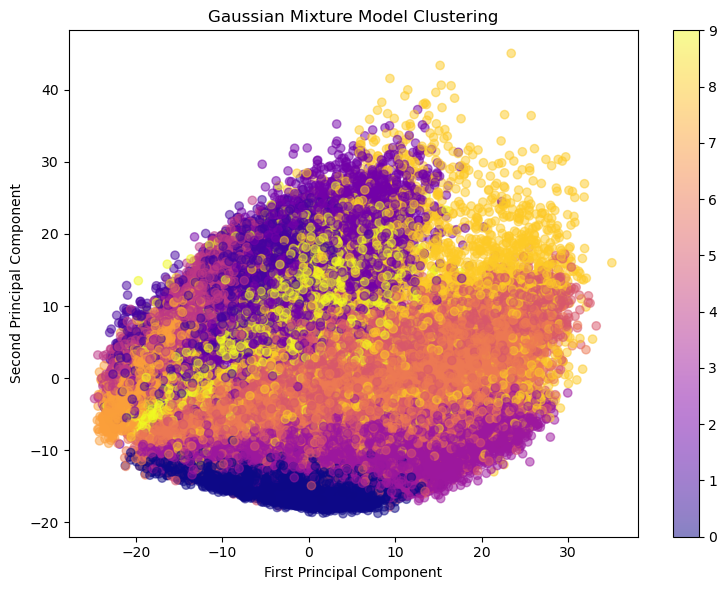

In [27]:
# GMM 적용
gmm = GaussianMixture(n_components=10, random_state=42)
clusters_gmm = gmm.fit_predict(X_transformed)

# 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=clusters_gmm, cmap='plasma', alpha=0.5)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

In [ ]:
# 2차원으로 PCA 추가 변환
pca_2d = PCA(n_components=2)
X_transformed_2d = pca_2d.fit_transform(X_transformed)

# Agglomerative Clustering 적용
agg_clustering = AgglomerativeClustering(n_clusters=10)
clusters_agg = agg_clustering.fit_predict(X_transformed)

# 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_transformed_2d[:, 0], X_transformed_2d[:, 1], c=clusters_agg, cmap='plasma', alpha=0.5)
plt.title('Agglomerative Clustering on PCA-reduced Data (2D)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

#cpu 성능으로 코드가 제대로 작동하지 않아 일단 코드만 작성합니다....

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [17]:
# GMM 적용
gmm = GaussianMixture(n_components=10, random_state=42)
clusters_gmm = gmm.fit_predict(X_transformed)

# 실루엣 점수 계산
silhouette_gmm = silhouette_score(X_transformed, clusters_gmm)

print(f"GMM Silhouette Score: {silhouette_gmm:.3f}")

GMM Silhouette Score: 0.090


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

0.090의 점수는 0.25보다 훨씬 낮아, 매우 낮은 클러스터링 품질을 의미한다.
GMM 모델의 파라미터를 조정하거나 다른 클러스터링 알고리즘을 시도해보는 것이 좋을 것 같다.